<h2>1. Importing modules </h2>

Pandas is required in order to manage the dataframe
Numpy is used to handle numpy arrays
os and path are used to access particular files

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt
from IPython.display import Markdown

<h2>Importing data</h2>

In [2]:
df = pd.read_csv("prospective.csv")
df = df.drop(columns = ['Unnamed: 2'])
df.columns = ["Unix", "Event"]

duration = []
for i in range(len(df)-1):
    duration.append(df.Unix[i+1] - df.Unix[i])
duration.append(0)

df["Duration"] = duration

print(df)
print("note Unix is still in miliseconds")

              Unix              Event  Duration
0    1571236317025         screen off      2665
1    1571236319690          screen on       137
2    1571236319827  App: Usage Logger      2301
3    1571236322128       user present       724
4    1571236322852     App: Quickstep     12239
..             ...                ...       ...
455  1571295145875          screen on      3841
456  1571295149716       user present     21375
457  1571295171091       App: YouTube    185643
458  1571295356734     App: Quickstep      3054
459  1571295359788  App: Usage Logger         0

[460 rows x 3 columns]
note Unix is still in miliseconds


<h2>Establishing variables</h2>

<h3>Screen usage</h3>
This is established through excluding all screen off events and the summing the duration. 

Then, establihing the different usage rates per day

In [3]:
startOfUsage = 0
usage = 0
screenState = "none"
for i in range(len(df)):
    if df.Event[i] == "screen on" and screenState != "screen on":
        startOfUsage = df.Unix[i]
        screenState = "screen on"
    if df.Event[i] == "screen off" and screenState == "screen on":
        usage += (df.Unix[i] - startOfUsage)
        startOfUsage = 0
        screenState = "screen off"
print("milliseconds smartphone used for: ", usage)
print("hours smartphone used for:",usage/1000/60/60)

#now returning the time per day
df["dateTime"] = [datetime.fromtimestamp(time) for time in df.Unix/1000]
df["days"] = [datetime.fromtimestamp(time).day for time in df.Unix/1000]

for currentDay in df["days"].unique():
    dayDF = df[df["days"] == currentDay]
    startOfUsage = 0
    usage = 0
    screenState = "none"
    
    dayDF.index = range(len(dayDF))
    
    for i in range(len(dayDF)):
        if dayDF.Event[i] == "screen on" and screenState != "screen on":
            startOfUsage = dayDF.Unix[i]
            screenState = "screen on"
        if dayDF.Event[i] == "screen off" and screenState == "screen on":
            usage += (dayDF.Unix[i] - startOfUsage)
            startOfUsage = 0
            screenState = "screen off"
    print("on day " + str(currentDay), "milliseconds smartphone used for: ", usage)
    print("on day " + str(currentDay),"hours smartphone used for:",usage/1000/60/60)



            

milliseconds smartphone used for:  7006371
hours smartphone used for: 1.9462141666666668
on day 16 milliseconds smartphone used for:  3572664
on day 16 hours smartphone used for: 0.9924066666666668
on day 17 milliseconds smartphone used for:  3433707
on day 17 hours smartphone used for: 0.9538074999999999


<h3>Establishing top used apps</h3>
This is done by creating a new dataframe for each of the apps and then summing up the duration which they were used. 

In [4]:
events = df.Event.unique()
Apps = []
AppUsageDF = pd.DataFrame(columns = ["App","Duration"])


for event in events:
    if str(event)[0:3] == "App":
        Apps.append(str(event))

for app in Apps:
    appDF = df[df.Event == app]
    lenAppUsage = len(AppUsageDF)
    AppUsageDF.at[lenAppUsage, "App"] = app
    AppUsageDF.at[lenAppUsage, "Duration"] = sum(appDF.Duration)/1000/60/60
    
AppUsageDF = AppUsageDF.sort_values(by=['Duration'], ascending=False)
AppUsageDF.index = range(len(AppUsageDF))
print(AppUsageDF)


                          App     Duration
0              App: Polytopia     0.566748
1                 App: TikTok     0.290973
2                App: YouTube     0.233675
3                 App: Chrome     0.151065
4           App: Usage Logger    0.0818372
5              App: Quickstep    0.0561014
6               App: WhatsApp    0.0353303
7               App: Messages    0.0261453
8   App: Google Play services    0.0138631
9                  App: Phone    0.0127903
10     App: Google Play Store   0.00920389
11            App: DuckDuckGo   0.00734278
12              App: Settings   0.00661639
13                 App: Clock   0.00480583
14               App: Audible   0.00198194
15                App: Camera      0.00181
16          App: Best Brokers   0.00138083
17                 App: Gmail  0.000493889
18      App: Contacts Storage  0.000488333
19        App: Android system  0.000433333
20     App: Package installer  0.000111944


<h1>Integrating context</h1>

Adding the context to provide information about usage. 

In the following example, we will review how many apps which are permitted to access the user's location are used of the course of the day. 

Finally, seeing the duration of usage for location enable apps across the two days

In [5]:
context = pd.read_csv("context.csv")
context = context.drop(columns = ['Unnamed: 3'])
context.columns = ["app", "permission", "response"]

#ensuring that context only reflects location detecting apps
context = context[context["permission"] == "android.permission.ACCESS_FINE_LOCATION"]
context = context[context["response"] == True]

locationSensingApps = context.app.values
locationSensingApps = ["App: " + i for i in locationSensingApps]

localeDF = df[df.Event.isin(locationSensingApps)]
localeDF.index = range(len(localeDF))

print("duration of usage across the two days for location sensing apps:", sum(localeDF.Duration)/1000/60/60)

duration of usage across the two days for location sensing apps: 0.206875


<h1>Visualsisations</h1>

The visualisations will include three different visualisations:

<ol>
    <li>A monochrome time based bar graph of when the smartphone was on</li>
    <li>A coloured time based graph of when the top five used apps (of that day) were eployed</li>
    <li>A monochrome time based bar graph of when the location sensing apps were employed </li>
</ol>


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


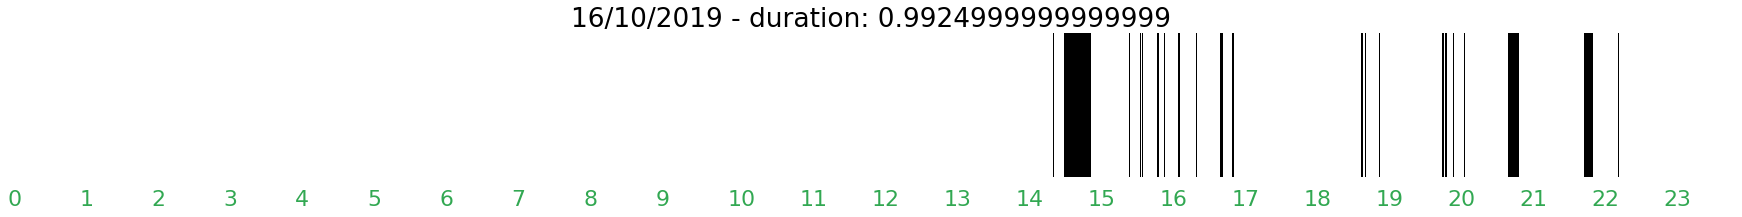

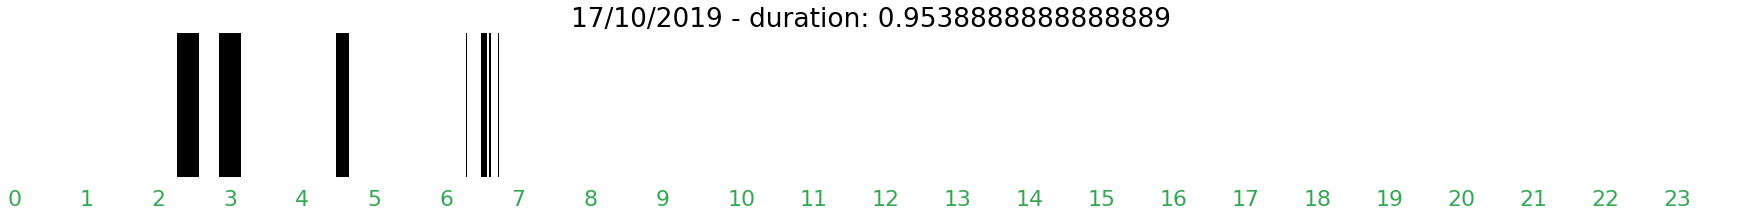

In [6]:
vDF = df.copy()
vDF.Unix = (vDF.Unix/1000).astype(int)
vDF["dateTime"] = [datetime.fromtimestamp(time) for time in vDF.Unix]
vDF["days"] = [datetime.fromtimestamp(time).day for time in vDF.Unix]
vDF = vDF[(vDF.Event == "screen on") | (vDF.Event == "screen off")]

dayData = [vDF[vDF["days"] == day] for day in vDF.days.unique()]

## pd.set_option('mode.chained_assignment', None)

for day in dayData:
    
    if day.iloc[len(day)-1].Event == "screen on":
        day = day.iloc[0:len(day)-1]
    
    day.index = range(len(day))
    sec = []

    day["Duration"] = day["Duration"].astype(int)

    midnight = day.dateTime[0].replace(hour=0, minute=0, second=0, microsecond=0)
    midnight = midnight.timestamp()
    
    durationOfEvent = 0
    screenState = "none"
    uDuration = 0
    for i in range(60*60*24):
        
        currentTime = int(midnight+i)
        if durationOfEvent < 3:
            if (currentTime == day.Unix).any():
                currentRow = day[day["Unix"] == currentTime]
                if currentRow.Event[currentRow.index[0]] == "screen on":
                    screenState = "screen on"
                if currentRow.Event[currentRow.index[0]] == "screen off":
                    screenState = "screen off"
        if screenState == "screen on":
            sec.append(True)
            durationOfEvent-=1
            uDuration += 1
        else:
            sec.append(False)
            
    barprops = dict(aspect="auto", cmap="binary", interpolation = "nearest")
    fig = plt.figure()
    plt.rcParams.update({'font.size': 22})

    ax = fig.add_axes([1,1,4,.5])
    ax.set_axis_off()
    sec = np.asarray(sec)
    for hour in range(24):

        ax.text(x = (len(sec)/24)*hour, y = .7, s = hour, color="#32a852" )

    ax.imshow(sec.reshape((1,-1)), **barprops)

    title = str(day.dateTime[0].day) + "/" + str(day.dateTime[0].month) + "/" + str(day.dateTime[0].year) 
    plt.title(str(title) + " - duration: " + str(uDuration/60/60))

    plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


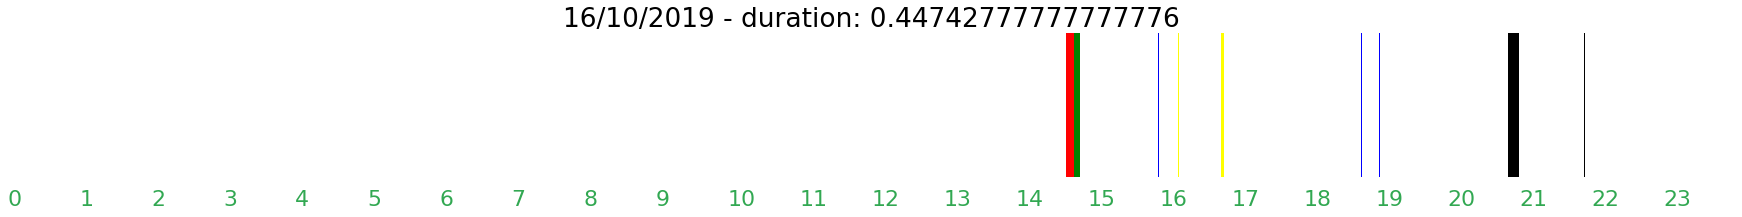

App: TikTok is coloured as <span style="color:black">black</span>.

App: YouTube is coloured as <span style="color:red">red</span>.

App: Usage Logger is coloured as <span style="color:green">green</span>.

App: Chrome is coloured as <span style="color:yellow">yellow</span>.

App: WhatsApp is coloured as <span style="color:blue">blue</span>.

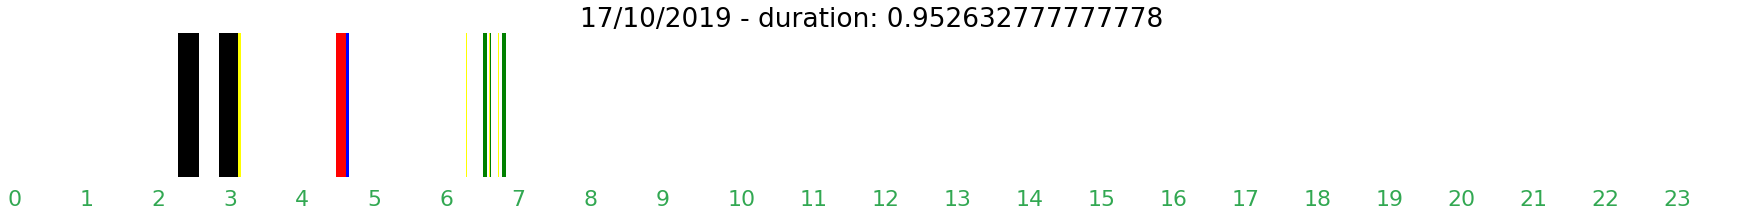

App: Polytopia is coloured as <span style="color:black">black</span>.

App: TikTok is coloured as <span style="color:red">red</span>.

App: YouTube is coloured as <span style="color:green">green</span>.

App: Chrome is coloured as <span style="color:yellow">yellow</span>.

App: Quickstep is coloured as <span style="color:blue">blue</span>.

In [7]:
vDF = df.copy()
vDF.Unix = (vDF.Unix/1000).astype(int)
vDF["dateTime"] = [datetime.fromtimestamp(time) for time in vDF.Unix]
vDF["days"] = [datetime.fromtimestamp(time).day for time in vDF.Unix]

dayData = [vDF[vDF["days"] == day] for day in vDF.days.unique()]

## pd.set_option('mode.chained_assignment', None)

for day in dayData:
    
    events = day.Event.unique()
    Apps = []
    AppUsageDF = pd.DataFrame(columns = ["App","Duration"])

    for event in events:
        if str(event)[0:3] == "App":
            Apps.append(str(event))

    for app in Apps:
        appDF = day[day.Event == app]
        lenAppUsage = len(AppUsageDF)
        AppUsageDF.at[lenAppUsage, "App"] = app
        AppUsageDF.at[lenAppUsage, "Duration"] = sum(appDF.Duration)/60/60

        
    AppUsageDF = AppUsageDF.sort_values(by=['Duration'], ascending=False)
    AppUsageDF.index = range(len(AppUsageDF))
    AppUsageDF = AppUsageDF.iloc[:5]

    day = day[day["Event"].isin(AppUsageDF.App)]
    
    employedApps = ["not an app"]
    
    for app in AppUsageDF.App:
        employedApps.append(app)
    
    colors = ListedColormap(["white","black", "red", "green","yellow","blue"])
    
    day.index = range(len(day))
    sec = []

    day["Duration"] = day["Duration"].astype(int)

    midnight = day.dateTime[0].replace(hour=0, minute=0, second=0, microsecond=0)
    midnight = midnight.timestamp()
    
    durationOfEvent = 0
    screenState = "none"
    uDuration = 0
    
    for i in range(60*60*24):
        
        currentTime = int(midnight+i)
        if durationOfEvent < 3:
            if (currentTime == day.Unix).any():
                currentRow = day[day["Unix"] == currentTime]

                durationOfEvent = currentRow.Duration[currentRow.index[0]]/1000
                uDuration += currentRow.Duration[currentRow.index[0]]/1000
                currentApp = currentRow.Event[currentRow.index[0]]
                typeOfEvent = employedApps.index(currentApp)

        if durationOfEvent > 0:
            sec.append(typeOfEvent)
            durationOfEvent-=1
        else:
            sec.append(0)
            
    barprops = dict(aspect="auto", cmap=colors, interpolation = "nearest")
    fig = plt.figure()
    plt.rcParams.update({'font.size': 22})

    ax = fig.add_axes([1,1,4,.5])
    ax.set_axis_off()
    sec = np.asarray(sec)
    for hour in range(24):

        ax.text(x = (len(sec)/24)*hour, y = .7, s = hour, color="#32a852" )

    ax.imshow(sec.reshape((1,-1)), **barprops)

    title = str(day.dateTime[0].day) + "/" + str(day.dateTime[0].month) + "/" + str(day.dateTime[0].year) 
    plt.title(str(title) + " - duration: " + str(uDuration/60/60))

    plt.show()
    
    for i in range(len(employedApps)):
        if employedApps[i] != "not an app":
            display (Markdown(str(employedApps[i]) +  ' is coloured as <span style="color:' + colors.colors[i]+'">' + colors.colors[i] +'</span>.'))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


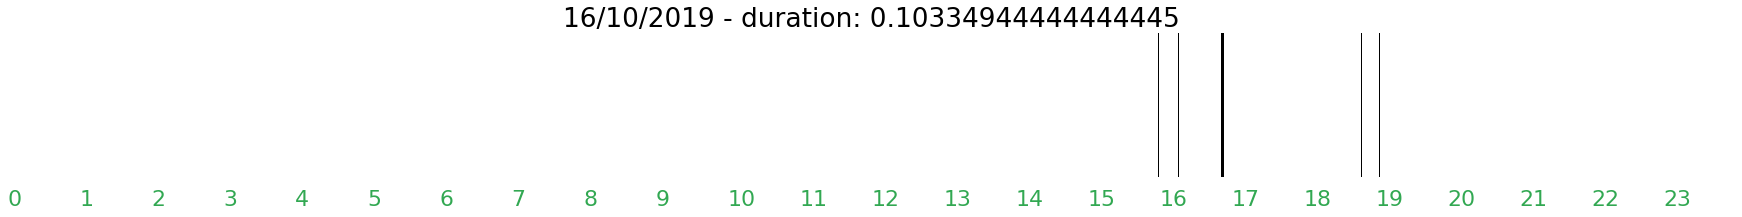

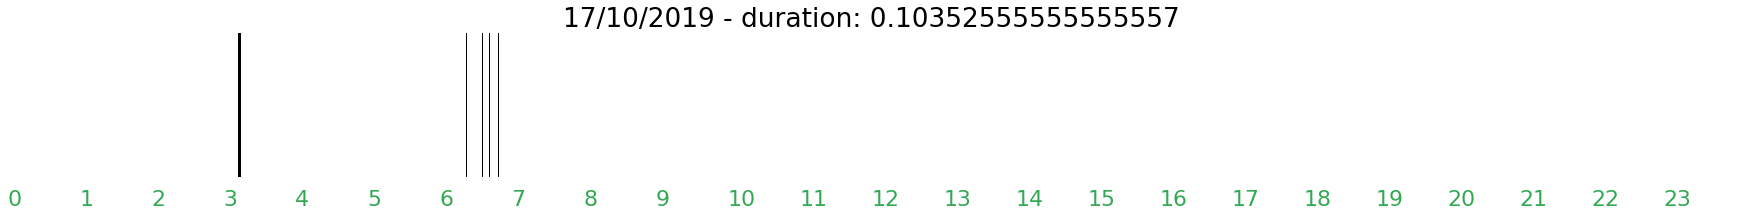

In [8]:
vDF = df.copy()
vDF.Unix = (vDF.Unix/1000).astype(int)
vDF["dateTime"] = [datetime.fromtimestamp(time) for time in vDF.Unix]
vDF["days"] = [datetime.fromtimestamp(time).day for time in vDF.Unix]

context = pd.read_csv("context.csv")
context = context.drop(columns = ['Unnamed: 3'])
context.columns = ["app", "permission", "response"]

#ensuring that context only reflects location detecting apps
context = context[context["permission"] == "android.permission.ACCESS_FINE_LOCATION"]
context = context[context["response"] == True]

locationSensingApps = context.app.values
locationSensingApps = ["App: " + i for i in locationSensingApps]

dayData = [vDF[vDF["days"] == day] for day in vDF.days.unique()]

## pd.set_option('mode.chained_assignment', None)

for day in dayData:
    
    day = day[day["Event"].isin(locationSensingApps)]
    
    day.index = range(len(day))
    sec = []

    day["Duration"] = day["Duration"].astype(int)

    midnight = day.dateTime[0].replace(hour=0, minute=0, second=0, microsecond=0)
    midnight = midnight.timestamp()
    
    durationOfEvent = 0
    uDuration = 0
    for i in range(60*60*24):
        
        currentTime = int(midnight+i)
        if durationOfEvent < 3:
            if (currentTime == day.Unix).any():
                currentRow = day[day["Unix"] == currentTime]

                durationOfEvent = currentRow.Duration[currentRow.index[0]]/1000
                uDuration += currentRow.Duration[currentRow.index[0]]/1000

        if durationOfEvent > 0:
            sec.append(True)
            durationOfEvent-=1
        else:
            sec.append(False)
            
    barprops = dict(aspect="auto", cmap="binary", interpolation = "nearest")
    fig = plt.figure()
    plt.rcParams.update({'font.size': 22})

    ax = fig.add_axes([1,1,4,.5])
    ax.set_axis_off()
    sec = np.asarray(sec)
    for hour in range(24):

        ax.text(x = (len(sec)/24)*hour, y = .7, s = hour, color="#32a852" )

    ax.imshow(sec.reshape((1,-1)), **barprops)

    title = str(day.dateTime[0].day) + "/" + str(day.dateTime[0].month) + "/" + str(day.dateTime[0].year) 
    plt.title(str(title) + " - duration: " + str(uDuration/60/60))

    plt.show()